# IA - Projeto 2: Fraude Bancária

Para este Projeto foi-nos proposta a análise de modelos de IA treinados por 3 algoritmos de supervised learning à nossa escolha de forma a percebermos como funcionam e o pré-processamento que a análise de dados e de algoritmos de classsificação precisam.

Assim, para o desenvolvimento deste trabalho selecionamos treinar o nosso modelo com os seguintes algoritmos de supervised learning no âmbito dos problemas de classsificação:
- Decision Tree
- Neural Network
- K Nearest Neighbour (KNN)

Ao longo deste Notebook vamos apresentar todos os passos que demos para chegar aos resultados obtidos pelos nossos modelos.

## Dependências

In [1]:
import itertools
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

## Dataset

O dataset que estamos a usar para treinar o nosso algoritmo contém 32 variáveis e 1000000 linhas de dados.

In [2]:
data = pd.read_csv('datasets/Base.csv')

## Preprocessamento de dados

Depois de analisar o dataset verificamos que para treinarmos os modelos, seria necessário fazer um pré-processamento dos dados para os limpar, balancear (uma vez que são desbalanceados, o número de fraudes é muito inferior ao número de não fraudes), converter para a mesma escala e transformar os valores das varíaveis categóricas por valores numéricos.
Assim, apresentamos em seguida os passos que demos durante esta fase do Projeto.

### Valores em falta
Lidar com missing values

Eliminámos as colunas com dados em falta, já que uma grande parte das instâncias não tinham valor.

In [3]:
x = data.drop(['fraud_bool', 'bank_months_count', 'prev_address_months_count'], axis=1)
y = data['fraud_bool']

### Encoding
Algumas das colunas continham valores de texto, pelo que têm de ser convertidas em números. 

### One-hot Encoding
Um One-hot Encoder pega nas categorias de uma coluna e as divide-as em várias colunas, cada uma representando uma categoria, essas colunas são preenchidas com valor 0 ou 1 dependendo do valor original. As colunas `'payment_type', 'employment_status, 'housing_status', 'device_os', 'source'` precisam de ser codificadas deste modo.

In [4]:
onehot_cols = ['payment_type', 'employment_status', 'housing_status', 'device_os', 'source']
onehot_transformer = ColumnTransformer([('encoder', OneHotEncoder(), onehot_cols)], remainder='passthrough')
x = pd.DataFrame(onehot_transformer.fit_transform(x))

### Scaling
O objetivo é normalizar as variáveis de entrada, garantindo que elas estejam na mesma escala antes de as passar o algoritmo de aprendizagem. Para isto, utilizamos o `StandardScaler`

In [5]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(scaler.fit_transform(x))

### Dados desbalanceados
O dataset é muito desbalanceado, com apenas 1% da classe positiva (fraude). Isto pode ser um problema para os algoritmos, pelo que fizemos oversampling dos dados utilizando `SMOTE`

In [6]:
oversampler = SMOTE(random_state=42)
x, y = oversampler.fit_resample(x, y)

## Algoritmos utilizados para treinar os Modelos

### Decision Tree

#### Divisão dos dados
Utilizamos 80% dos dados para treino e 20% para teste

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#### Parâmetros
Foram realizados testes para varios valores de `max_depth` e `min_samples_split` utilizando `RandomizedSearchCV`, utilizando como métrica a AUC-ROC.

Estes testes são muito demorados, então não é recomendado executar este código. No treino do modelo, os melhores parâmetros que encontramos já são utilizados

In [8]:
params = {'max_depth': range(2,11),
          'min_samples_split': range(2,11),
         }
grid_search = RandomizedSearchCV(DecisionTreeClassifier(), params, cv=2, n_iter=20, scoring="roc_auc", verbose=3, n_jobs=-1)
grid_search.fit(xtrain, ytrain)

print("Best Parameters:")
print(grid_search.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits



KeyboardInterrupt



#### Treino

In [12]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=25, min_samples_split=25)
decision_tree_classifier.fit(xtrain, ytrain)
print(decision_tree_classifier)

DecisionTreeClassifier(max_depth=25, min_samples_split=25)


#### Resultados

- AUC-ROC

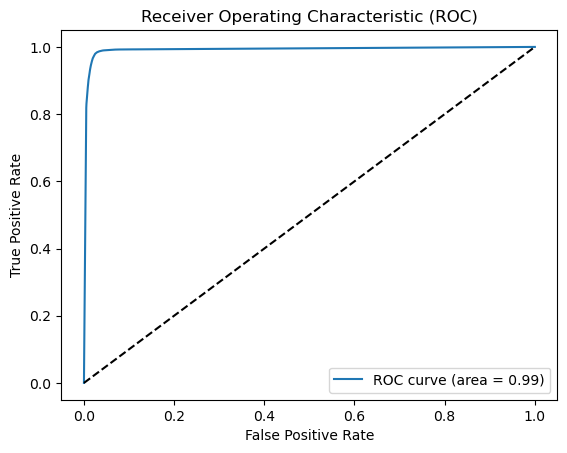

In [13]:
y_pred_proba = decision_tree_classifier.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
auc_roc = roc_auc_score(ytest, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

- Curva de aprendizagem

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(decision_tree_classifier, xtrain, ytrain, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Random Forest

#### Divisão dos dados
Utilizamos 80% dos dados para treino e 20% para teste

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#### Parâmetros
Foram realizados testes para varios valores de `max_depth` e `min_samples_split` utilizando `RandomizedSearchCV`, utilizando como métrica a AUC-ROC.

Estes testes são muito demorados, então não é recomendado executar este código. No treino do modelo, os melhores parâmetros que encontramos já são utilizados

In [ ]:
params = {  'n_estimators': range(50, 150, 10),
            'max_depth': range(2,11),
            'min_samples_split': range(2,11),
         }
grid_search = RandomizedSearchCV(RandomForestClassifier(), params, cv=2, n_iter=20, scoring="roc_auc", verbose=3, n_jobs=-1)
grid_search.fit(xtrain, ytrain)

print("Best Parameters:")
print(grid_search.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


Neste modelo usamos o Random Forest para verificarmos se obtíamos melhores resultados do que com a decision tree:

In [14]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, min_samples_split=8, max_depth=10)  # Enable parallel processing
random_forest_classifier.fit(xtrain, ytrain)

RandomForestClassifier(n_jobs=-1)

#### Resultados

- AUC-ROC

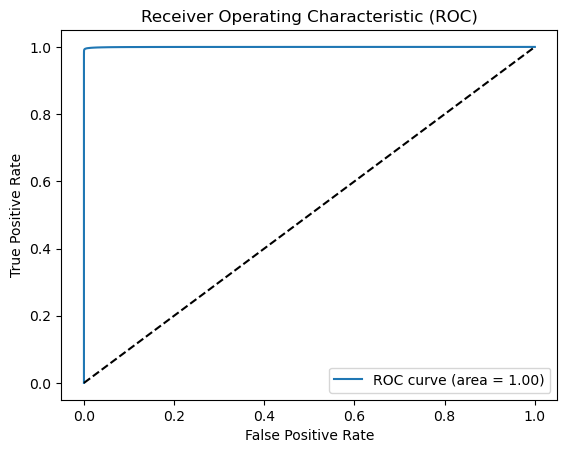

In [16]:
y_pred_proba = random_forest_classifier.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
auc_roc = roc_auc_score(ytest, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

- Curva de Aprendizagem

In [14]:
train_sizes, train_scores, test_scores = learning_curve(decision_tree_classifier, xtrain, ytrain, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

NameError: name 'decision_tree_classifier' is not defined

### Neural Network

#### Divisão de dados

Utilizamos 85% dos dados para treino e 15% para teste.

In [24]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.85, random_state=0)
print("Length of x: ", len(xTrain))

Length of x:  296691


#### Parâmetros

Foram realizados testes para varios valores de `hidden_layer_sizes`, `activation` e `solver` utilizando RandomizedSearchCV, utilizando como métrica a AUC-ROC.

Estes testes são muito demorados, então não é recomendado executar este código. No treino do modelo, os melhores parâmetros que encontramos já são utilizados.

In [18]:
hidden_layers_list = []
for num_layers in range(1, 3):  # Varying number of hidden layers from 1 to 2
    for layer_size in itertools.product(range(20, 101, 10), repeat=num_layers):
        hidden_layers_list.append(layer_size)

print("Length: ", len(hidden_layers_list))
print(hidden_layers_list)

param_distributions = {'hidden_layer_sizes': hidden_layers_list,
                       'activation': ['relu', 'logistic'],
                       'solver': ['adam'],
                       }

grid_search = RandomizedSearchCV(MLPClassifier(), param_distributions, cv=3, n_iter=20, scoring="roc_auc", verbose=3, 
                                 n_jobs=-1)
grid_search.fit(xTrain, yTrain)

print("Best Parameters:")
print(grid_search.best_params_)

Length:  90
[(20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (20, 20), (20, 30), (20, 40), (20, 50), (20, 60), (20, 70), (20, 80), (20, 90), (20, 100), (30, 20), (30, 30), (30, 40), (30, 50), (30, 60), (30, 70), (30, 80), (30, 90), (30, 100), (40, 20), (40, 30), (40, 40), (40, 50), (40, 60), (40, 70), (40, 80), (40, 90), (40, 100), (50, 20), (50, 30), (50, 40), (50, 50), (50, 60), (50, 70), (50, 80), (50, 90), (50, 100), (60, 20), (60, 30), (60, 40), (60, 50), (60, 60), (60, 70), (60, 80), (60, 90), (60, 100), (70, 20), (70, 30), (70, 40), (70, 50), (70, 60), (70, 70), (70, 80), (70, 90), (70, 100), (80, 20), (80, 30), (80, 40), (80, 50), (80, 60), (80, 70), (80, 80), (80, 90), (80, 100), (90, 20), (90, 30), (90, 40), (90, 50), (90, 60), (90, 70), (90, 80), (90, 90), (90, 100), (100, 20), (100, 30), (100, 40), (100, 50), (100, 60), (100, 70), (100, 80), (100, 90), (100, 100)]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

#### Treino

In [26]:
neural_network = MLPClassifier(hidden_layer_sizes=(80,40), activation='logistic', solver='adam', random_state=0)
neural_network.fit(xTrain, yTrain)

C:\Users\wrtan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(80, 40),
              random_state=0)

#### Resultados

- AUC-ROC

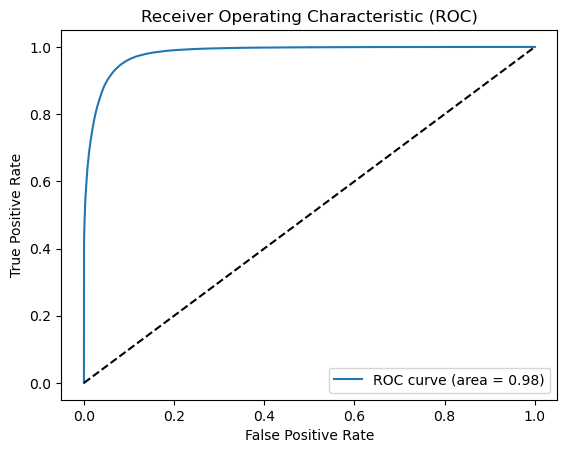

In [27]:
y_pred_proba = neural_network.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
auc_roc = roc_auc_score(ytest, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

- Curva de Aprendizagem

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(neural_network, xtrain, ytrain, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### KNN

#### Divisão de dados

Utilizamos 80% dos dados para treino e 20% para teste.

In [1]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

#### Parâmetros

Foram realizados testes para varios valores de `weights`, `leaf_size` e `p` utilizando `RandomizedSearchCV`, utilizando como métrica a AUC-ROC.

Estes testes são muito demorados, então não é recomendado executar este código. No treino do modelo, os melhores parâmetros que encontramos já são utilizados.

In [ ]:
params = {  'weights': ['uniform', 'distance'],
            'leaf_size': range(10, 51, 10),
            'p': [1, 2]
          }
grid_search = RandomizedSearchCV(KNeighborsClassifier(), params, cv=2, n_iter=20, scoring="roc_auc", verbose=3,n_jobs=-1)
grid_search.fit(xtrain, ytrain)
print("Best Parameters:")
print(grid_search.best_params_)

Acabamos por alterar apenas o `n_neighbors`, uma vez que como os testes eram muito demorados, os que fizemos não permitiram concluir muito impacto na mudança de algumas destas variáveis e por isso optamos por mudar apenas este parâmetro.

#### Treino

In [15]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(xtrain, ytrain)

KNeighborsClassifier()

#### Resultados

- AUC-ROC

In [ ]:
y_pred_proba = knn_classifier.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
auc_roc = roc_auc_score(ytest, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

- Curva de aprendizagem

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(knn_classifier, xtrain, ytrain, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Com este modelo conseguimos obter um resultado ROC de **91%**. Um dos parâmetros do algoritmo que usamos `KNeighborsClassifier` que tem bastante impacto neste resultado é no `n_neighbors` (que representa o número de vizinhos do nó atual que vamos visitar). Reparamos que quanto maior o número de vizinhos, pior o desempenho deste modelo. Pelo que o resultado ótimo, foi encontrado com `n_neighbors=5`.

Durante o período de testes e experiência, reparamos também que a normalização das variáveis tem um grande impacto neste algoritmo, uma vez que quando usamos outra forma de pre-processamento obtivemos um resultado de 60%. Muito possivelmente, porque os relevantes para o modelo não estavam tratados.

## Análise e Comparação de Resultados

Para conseguirmos analisar e comparar os 3 modelos que treinamos, usamos várias métricas de entre as quais destacamos:
- **AUC-ROC**
- **Matriz de confusão**
- **Curva de Aprendizagem**


De acordo com os resultados obtidos a partir dos gráficos de AUC-ROC, verificamos que o melhor resultado foi o que obtivemos com o algoritmo de Decision Tree que deu uma taxa de acerto de **99%**. Com o Random Forest obtivemos uma taxa de **100%**, mas será porque fez overfitting dos dados e por isso deixa de ser relevante os resultados obtidos por este modelo.
Relativamente às neural networks também obtivemos bons resultados, mas demora muito mais tempo a executar, e por isso não compensa a utilização do mesmo para este género de datasets.

## Conclusão